<a href="https://www.kaggle.com/code/anindyajana/almost-any-multiclass-image-classification-cnn?scriptVersionId=167012049" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
import os
import numpy as np

import cv2 
import matplotlib.pyplot as plt
from PIL import Image

import tensorflow as tf
from tensorflow.keras.utils import load_img
from tensorflow.keras.preprocessing import image
import tensorflow.keras.layers as tensor

import keras
from keras.utils import image_dataset_from_directory
from tqdm.notebook import tqdm 

print(tf.__version__)
#this notebook works on both keras v2 and v3 
print(keras.__version__)

2.10.0

2.10.0


In [2]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


# Loading the Data
This dataset contains three folders:

train (100 images each)

test (10 images each)

validation (10 images each) 

each of the above folders contains subfolders for different fruits and vegetables wherein the images for respective food items are present

Using keras image_dataset_from_directory function to load data directly to model and get the labels from the folder name.
 
If a validation folder is not present, you can use validation split from the train_generator.

In [3]:
image_directory="/kaggle/input/fruit-and-vegetable-image-recognition/"#specify the image directory
image_dimension=256 #global image dimension

train_generator=keras.utils.image_dataset_from_directory(
    image_directory+"train/",
    labels="inferred",
    label_mode="categorical",
    class_names=None,
    color_mode="rgb",
    batch_size=32,
    image_size=(image_dimension,image_dimension),
    shuffle=True,
    seed=None,
    validation_split=None,
    interpolation="bilinear",
    follow_links=False,
    crop_to_aspect_ratio=False,
)
validation_generator=keras.utils.image_dataset_from_directory(
    image_directory+"validation/",
    labels="inferred",
    label_mode="categorical",
    class_names=None,
    color_mode="rgb",
    batch_size=32,
    image_size=(image_dimension,image_dimension),
    shuffle=True,
    seed=None,
    validation_split=None,
    interpolation="bilinear",
    follow_links=False,
    crop_to_aspect_ratio=False,
)

Found 3115 files belonging to 36 classes.

Found 351 files belonging to 36 classes.


## Generating labels
This labels are  used in predicting the accuracy of test images

In [4]:
output_parameter=len(train_generator.class_names)
lst=train_generator.class_names
res_dict = {}
for i in range(0,output_parameter):
   res_dict[i] = lst[i]
print(res_dict)

{0: 'apple', 1: 'banana', 2: 'beetroot', 3: 'bell pepper', 4: 'cabbage', 5: 'capsicum', 6: 'carrot', 7: 'cauliflower', 8: 'chilli pepper', 9: 'corn', 10: 'cucumber', 11: 'eggplant', 12: 'garlic', 13: 'ginger', 14: 'grapes', 15: 'jalepeno', 16: 'kiwi', 17: 'lemon', 18: 'lettuce', 19: 'mango', 20: 'onion', 21: 'orange', 22: 'paprika', 23: 'pear', 24: 'peas', 25: 'pineapple', 26: 'pomegranate', 27: 'potato', 28: 'raddish', 29: 'soy beans', 30: 'spinach', 31: 'sweetcorn', 32: 'sweetpotato', 33: 'tomato', 34: 'turnip', 35: 'watermelon'}


## Visualise the images

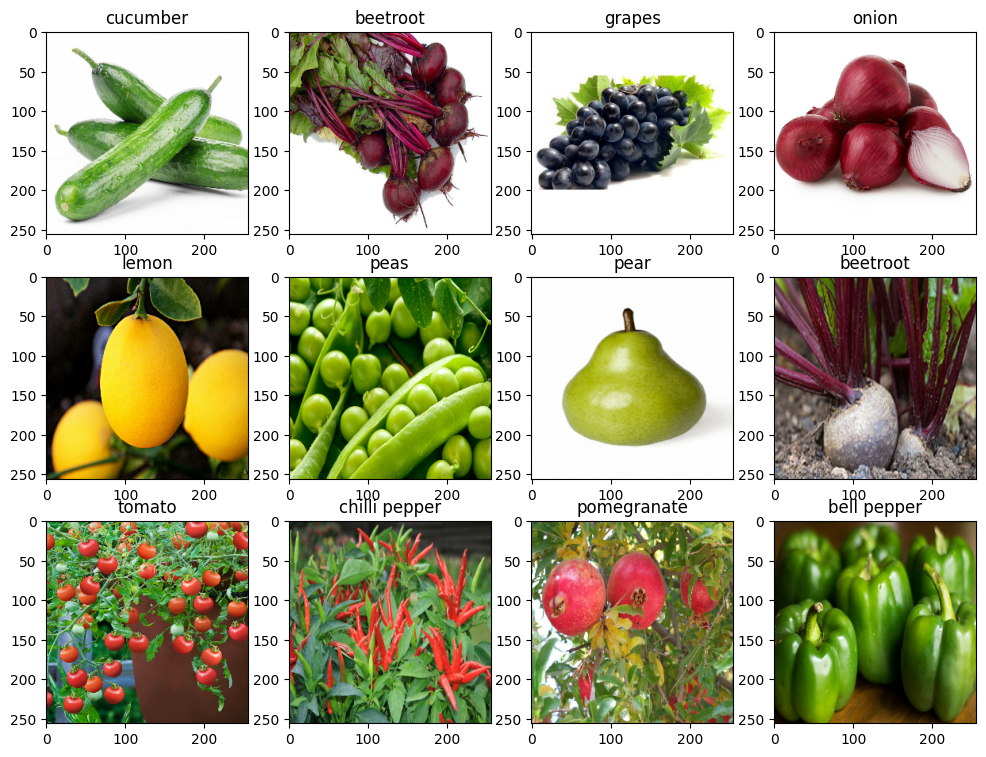

In [5]:
plt.figure(figsize=(12, 9))
for images, labels in train_generator.take(1):
    for i in range(12):
        ax = plt.subplot(3, 4, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(res_dict[np.argmax(labels[i], axis=-1)])

# Building a simple CNN model

In [6]:
inp=tensor.Input(shape=(image_dimension,image_dimension,3))
#layer 1
conv1=tensor.Conv2D(32,kernel_size=(3,3),activation="relu",padding="same")(inp)
pool1=tensor.MaxPool2D(pool_size=(4,4))(conv1)
norm1=tensor.BatchNormalization(axis=-1)(pool1)
drop1=tensor.Dropout(rate=0.2)(norm1)
#layer 2
conv2=tensor.Conv2D(32,kernel_size=(3,3),activation="relu",padding="same")(drop1)
pool2=tensor.MaxPool2D(pool_size=(2,2))(conv2)
norm2=tensor.BatchNormalization(axis=-1)(pool2)
drop2=tensor.Dropout(rate=0.2)(norm2)

flat=tensor.Flatten()(drop2)

hidden1=tensor.Dense(256,activation="relu")(flat)#512 for better
norm3=tensor.BatchNormalization(axis=-1)(hidden1)
drop3=tensor.Dropout(rate=0.2)(norm3)

hidden2=tensor.Dense(128,activation="relu")(drop3)#256 for better
norm4=tensor.BatchNormalization(axis=-1)(hidden2)
drop4=tensor.Dropout(rate=0.2)(norm4)

out=tensor.Dense(output_parameter,activation="sigmoid")(drop4)

## compile the model
Then, we can compile it with some parameters such as:

1.Optimizer:adam = RMSProp + Momentum.

Momentum = takes into account past gradient to have a better update.
RMSProp = exponentially weighted average of the squares of past gradients.

Adam is an adaptive deep neural network training optimizer that has been used in most cases.

2.Loss function: we use categorical crossentropy for classification, each images belongs to one class only.

3.Metrics:we use the 'categorical_accuracy' metrics.This calculates how often predictions match one-hot labels.

In [7]:
model = keras.Model(inputs = inp , outputs = out)
model.compile(optimizer = "adam",loss="categorical_crossentropy",metrics = ['categorical_accuracy'])
print(model.summary())

Model: "model"

_________________________________________________________________

 Layer (type)                Output Shape              Param #   


 input_1 (InputLayer)        [(None, 256, 256, 3)]     0         

                                                                 

 conv2d (Conv2D)             (None, 256, 256, 32)      896       

                                                                 

 max_pooling2d (MaxPooling2D  (None, 64, 64, 32)       0         

 )                                                               

                                                                 

 batch_normalization (BatchN  (None, 64, 64, 32)       128       

 ormalization)                                                   

                                                                 

 dropout (Dropout)           (None, 64, 64, 32)        0         

                                                                 

 conv2d_1 (Conv2D)           (None, 64, 64, 3

## Train / fit the data to the model
Fit the model to the data from the train_generator.
The neural network will learn by itself the pattern in order to distinguish each category.

In [8]:
training=model.fit(train_generator,batch_size=8,epochs =20,verbose=1,validation_data=validation_generator,validation_steps=10)

Epoch 1/20

98/98 [==============================] - 30s 241ms/step - loss: 3.2112 - categorical_accuracy: 0.1612 - val_loss: 2.7072 - val_categorical_accuracy: 0.3000

Epoch 2/20

98/98 [==============================] - 24s 228ms/step - loss: 2.2908 - categorical_accuracy: 0.3429 - val_loss: 1.3829 - val_categorical_accuracy: 0.6438

Epoch 3/20

98/98 [==============================] - 24s 231ms/step - loss: 1.7582 - categorical_accuracy: 0.4944 - val_loss: 1.2459 - val_categorical_accuracy: 0.6562

Epoch 4/20

98/98 [==============================] - 24s 230ms/step - loss: 1.2509 - categorical_accuracy: 0.6501 - val_loss: 0.8918 - val_categorical_accuracy: 0.7594

Epoch 5/20

98/98 [==============================] - 24s 230ms/step - loss: 0.8185 - categorical_accuracy: 0.7904 - val_loss: 0.7099 - val_categorical_accuracy: 0.8125

Epoch 6/20

98/98 [==============================] - 25s 235ms/step - loss: 0.6069 - categorical_accuracy: 0.8411 - val_loss: 0.5472 - val_categorical_accu

## Ploting accuracy score

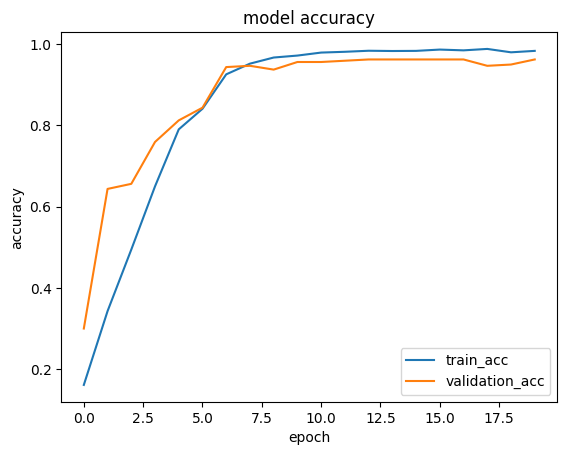

In [9]:
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.plot(training.history['categorical_accuracy'])
plt.plot(training.history['val_categorical_accuracy'])
plt.legend(['train_acc', 'validation_acc'])
plt.show()

# prediction
Creating a custom function to predict accuracy and analyze probability.

In [10]:
def predict(img_rel_path,show_details,show_indiv_probability):#prediction function
    # Import Image from the path with size of image dimension
    img = image.load_img(img_rel_path, target_size=(image_dimension, image_dimension))

    # Convert Image to a numpy array
    img = image.img_to_array(img, dtype=np.uint8)
    img = np.array(img)

    # Get the Predicted Label for the loaded Image
    p = model.predict(img[np.newaxis, ...])   
    predicted_class = res_dict[np.argmax(p[0], axis=-1)]
    
    if show_details:
        #Plotting the Loaded Image
        plt.figure(figsize=(4,4))
        plt.title("Loaded Image")
        plt.axis('off')
        plt.imshow(img.squeeze())
        plt.show() 
        
        print("Predicted label:", predicted_class)
    if show_indiv_probability:    
        print("Maximum Probability: ", np.max(p[0], axis=-1),"\n")
        classes=[]
        prob=[]
        print("\n--------------------------------Individual Probability---------------------------------------\n")

        for i,j in enumerate (p[0],0):
            print(res_dict[i].upper(),':',round(j*100,2),'%', end =" ")
            classes.append(res_dict[i])
            prob.append(round(j*100,2))

        def plot_bar_x():

            index = np.arange(len(classes))
            plt.figure(figsize=(10,5))
            plt.bar(index, prob)
            plt.xlabel('Labels', fontsize=12)
            plt.ylabel('Probability', fontsize=12)
            plt.xticks(index, classes, fontsize=12, rotation=90)
            plt.title('Probability for loaded image')
            
            plt.show()
        plot_bar_x()
            
    return predicted_class

## prediction of a single image

1/1 [==============================] - 0s 228ms/step


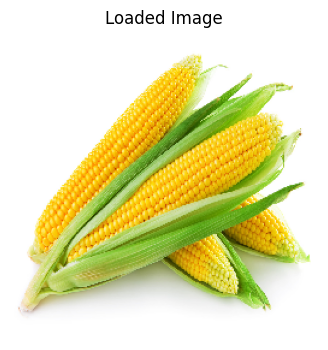

Predicted label: corn

Maximum Probability:  0.99999774 





--------------------------------Individual Probability---------------------------------------



APPLE : 89.89 % BANANA : 14.32 % BEETROOT : 53.45 % BELL PEPPER : 0.96 % CABBAGE : 90.19 % CAPSICUM : 41.47 % CARROT : 9.27 % CAULIFLOWER : 77.04 % CHILLI PEPPER : 1.86 % CORN : 100.0 % CUCUMBER : 38.57 % EGGPLANT : 0.89 % GARLIC : 0.95 % GINGER : 29.07 % GRAPES : 89.87 % JALEPENO : 0.91 % KIWI : 95.74 % LEMON : 99.52 % LETTUCE : 93.08 % MANGO : 26.58 % ONION : 8.68 % ORANGE : 97.62 % PAPRIKA : 35.93 % PEAR : 72.39 % PEAS : 19.26 % PINEAPPLE : 51.31 % POMEGRANATE : 21.38 % POTATO : 84.24 % RADDISH : 1.24 % SOY BEANS : 9.16 % SPINACH : 99.47 % SWEETCORN : 99.77 % SWEETPOTATO : 2.54 % TOMATO : 2.02 % TURNIP : 0.32 % WATERMELON : 85.5 % 

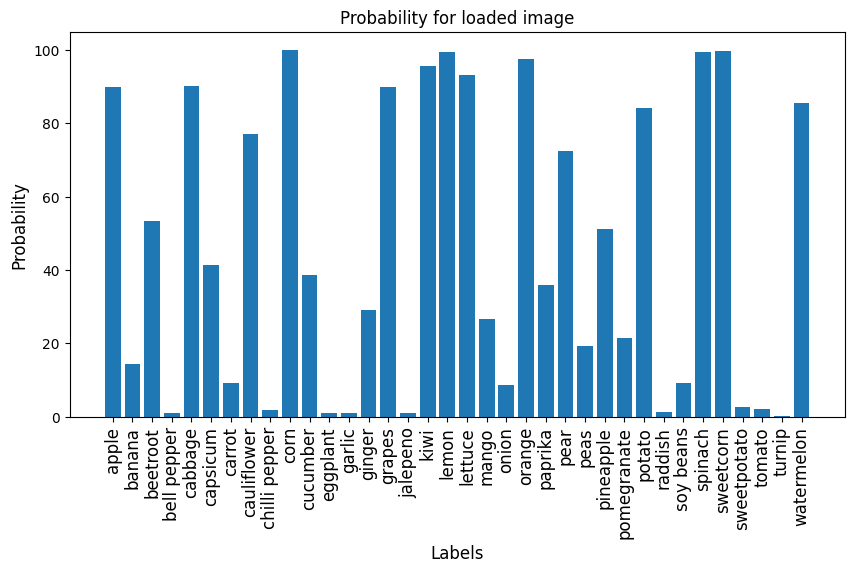

'corn'

In [11]:
predict(image_directory+"train/corn/Image_9.jpg",True,True)

## Viewing wrong predictions made on test dataset
wrong predictions may be due to improper images or using less accurate models.

  0%|          | 0/36 [00:00<?, ?it/s]

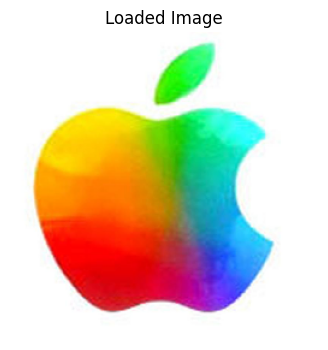

Predicted label: paprika

True label: apple


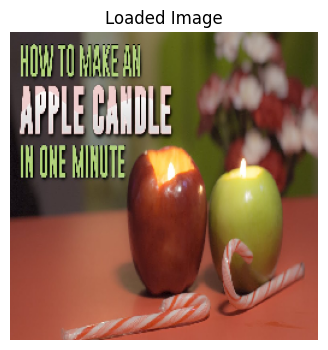

Predicted label: garlic

True label: apple


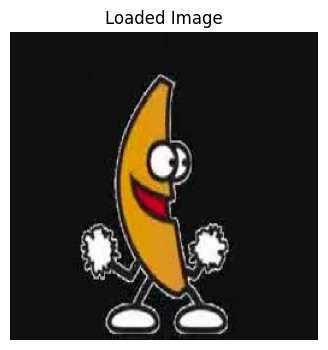

Predicted label: raddish

True label: banana


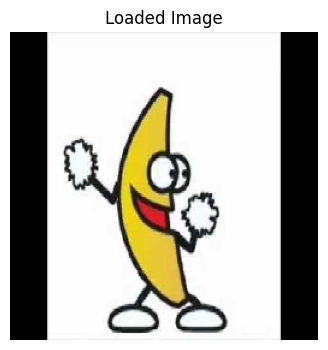

Predicted label: pineapple

True label: banana


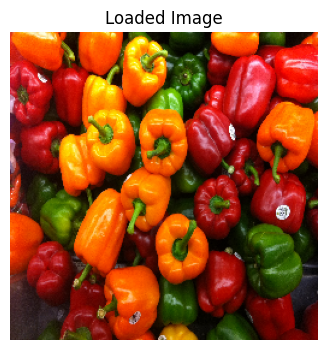

Predicted label: capsicum

True label: bell pepper


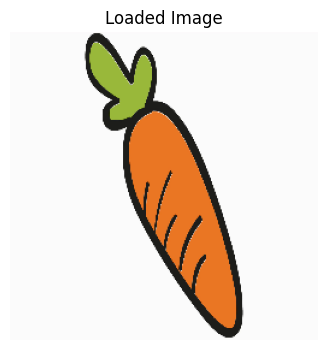

Predicted label: turnip

True label: carrot


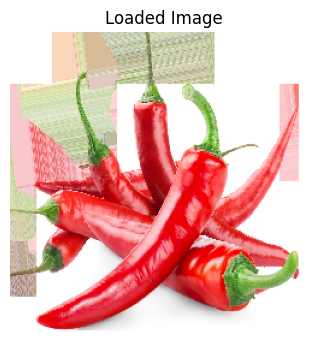

Predicted label: jalepeno

True label: chilli pepper


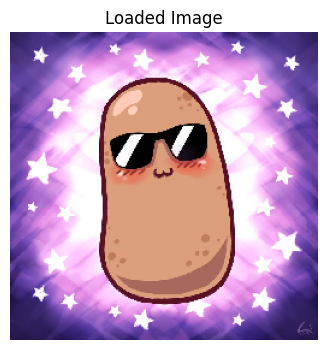

Predicted label: mango

True label: potato


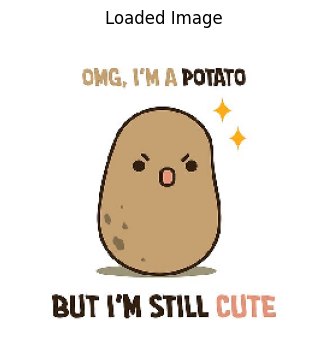

Predicted label: turnip

True label: potato


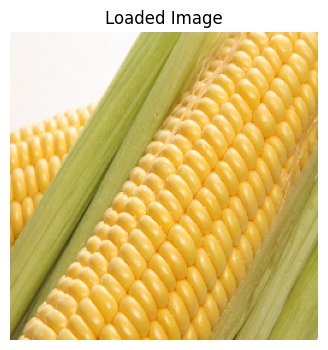

Predicted label: corn

True label: sweetcorn


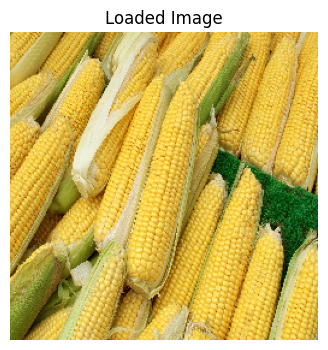

Predicted label: corn

True label: sweetcorn


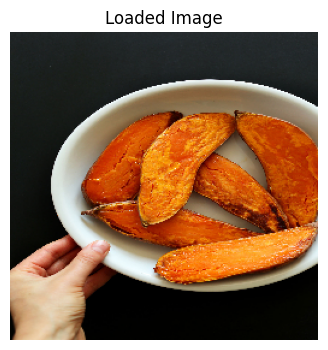

Predicted label: orange

True label: sweetpotato


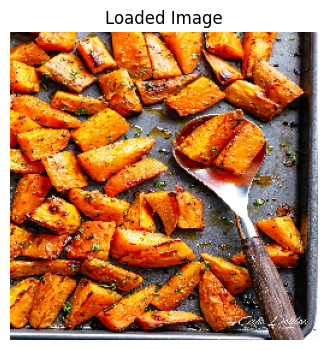

Predicted label: paprika

True label: sweetpotato


In [12]:
image_dir = image_directory+"test/"
tf.keras.utils.disable_interactive_logging()

for categories in tqdm(os.listdir(image_dir)):
    img_list = os.listdir(image_dir+categories)
    for i,img_name in enumerate(img_list):
                
        if predict(image_dir + categories+"\\" + img_name,False,False)!=categories:    
            predict(image_dir + categories+"\\" + img_name,True,False)
            print("True label: "+categories)

## predicting and calculating accuracy of all test images

In [13]:
image_dir = image_directory+"test/"
tf.keras.utils.enable_interactive_logging()
total_images=total_pred_c=0

for categories in os.listdir(image_dir):
    img_list = os.listdir(image_dir+categories)
    individual_pred_c=0
    for i,img_name in enumerate(tqdm(img_list)):
        total_images+=1
        if predict(image_dir + categories+"\\" + img_name,False,False)==categories:    
            individual_pred_c+=1
            total_pred_c+=1   

    print("Accuracy of detecting "+categories+" is :"+str(individual_pred_c/len(img_list)))   
print("\n Accuracy of detecting all test images is :"+str(total_pred_c/total_images))       

  0%|          | 0/10 [00:00<?, ?it/s]

1/1 [==============================] - 0s 23ms/step

1/1 [==============================] - 0s 21ms/step

1/1 [==============================] - 0s 23ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 21ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 27ms/step

1/1 [==============================] - 0s 21ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 21ms/step

Accuracy of detecting apple is :0.8


  0%|          | 0/9 [00:00<?, ?it/s]

1/1 [==============================] - 0s 24ms/step

1/1 [==============================] - 0s 23ms/step

1/1 [==============================] - 0s 17ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 23ms/step

1/1 [==============================] - 0s 23ms/step

1/1 [==============================] - 0s 24ms/step

1/1 [==============================] - 0s 24ms/step

1/1 [==============================] - 0s 23ms/step

Accuracy of detecting banana is :0.7777777777777778


  0%|          | 0/10 [00:00<?, ?it/s]

1/1 [==============================] - 0s 16ms/step

1/1 [==============================] - 0s 28ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 23ms/step

1/1 [==============================] - 0s 23ms/step

1/1 [==============================] - 0s 20ms/step

1/1 [==============================] - 0s 14ms/step

1/1 [==============================] - 0s 28ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 21ms/step

Accuracy of detecting beetroot is :1.0


  0%|          | 0/10 [00:00<?, ?it/s]

1/1 [==============================] - 0s 21ms/step

1/1 [==============================] - 0s 23ms/step

1/1 [==============================] - 0s 18ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 21ms/step

1/1 [==============================] - 0s 20ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 21ms/step

Accuracy of detecting bell pepper is :0.9


  0%|          | 0/10 [00:00<?, ?it/s]

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 23ms/step

1/1 [==============================] - 0s 23ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 23ms/step

1/1 [==============================] - 0s 19ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 21ms/step

1/1 [==============================] - 0s 27ms/step

1/1 [==============================] - 0s 26ms/step

Accuracy of detecting cabbage is :1.0


  0%|          | 0/10 [00:00<?, ?it/s]

1/1 [==============================] - 0s 27ms/step

1/1 [==============================] - 0s 21ms/step

1/1 [==============================] - 0s 23ms/step

1/1 [==============================] - 0s 21ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 21ms/step

1/1 [==============================] - 0s 27ms/step

1/1 [==============================] - 0s 17ms/step

1/1 [==============================] - 0s 21ms/step

Accuracy of detecting capsicum is :1.0


  0%|          | 0/10 [00:00<?, ?it/s]

1/1 [==============================] - 0s 16ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 19ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 25ms/step

1/1 [==============================] - 0s 26ms/step

1/1 [==============================] - 0s 26ms/step

1/1 [==============================] - 0s 21ms/step

1/1 [==============================] - 0s 21ms/step

Accuracy of detecting carrot is :0.9


  0%|          | 0/10 [00:00<?, ?it/s]

1/1 [==============================] - 0s 27ms/step

1/1 [==============================] - 0s 30ms/step

1/1 [==============================] - 0s 20ms/step

1/1 [==============================] - 0s 20ms/step

1/1 [==============================] - 0s 26ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 14ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 22ms/step

Accuracy of detecting cauliflower is :1.0


  0%|          | 0/10 [00:00<?, ?it/s]

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 23ms/step

1/1 [==============================] - 0s 28ms/step

1/1 [==============================] - 0s 23ms/step

1/1 [==============================] - 0s 26ms/step

1/1 [==============================] - 0s 21ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 21ms/step

Accuracy of detecting chilli pepper is :0.9


  0%|          | 0/10 [00:00<?, ?it/s]

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 16ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 28ms/step

1/1 [==============================] - 0s 28ms/step

1/1 [==============================] - 0s 21ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 23ms/step

1/1 [==============================] - 0s 21ms/step

1/1 [==============================] - 0s 20ms/step

Accuracy of detecting corn is :1.0


  0%|          | 0/10 [00:00<?, ?it/s]

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 14ms/step

1/1 [==============================] - 0s 20ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 17ms/step

1/1 [==============================] - 0s 21ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 21ms/step

Accuracy of detecting cucumber is :1.0


  0%|          | 0/10 [00:00<?, ?it/s]

1/1 [==============================] - 0s 21ms/step

1/1 [==============================] - 0s 21ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 21ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 24ms/step

1/1 [==============================] - 0s 21ms/step

1/1 [==============================] - 0s 21ms/step

Accuracy of detecting eggplant is :1.0


  0%|          | 0/10 [00:00<?, ?it/s]

1/1 [==============================] - 0s 24ms/step

1/1 [==============================] - 0s 14ms/step

1/1 [==============================] - 0s 24ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 24ms/step

1/1 [==============================] - 0s 23ms/step

1/1 [==============================] - 0s 27ms/step

1/1 [==============================] - 0s 21ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 22ms/step

Accuracy of detecting garlic is :1.0


  0%|          | 0/10 [00:00<?, ?it/s]

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 21ms/step

1/1 [==============================] - 0s 21ms/step

1/1 [==============================] - 0s 21ms/step

1/1 [==============================] - 0s 21ms/step

1/1 [==============================] - 0s 27ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 21ms/step

Accuracy of detecting ginger is :1.0


  0%|          | 0/10 [00:00<?, ?it/s]

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 23ms/step

1/1 [==============================] - 0s 21ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 16ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 21ms/step

1/1 [==============================] - 0s 18ms/step

1/1 [==============================] - 0s 24ms/step

1/1 [==============================] - 0s 23ms/step

Accuracy of detecting grapes is :1.0


  0%|          | 0/10 [00:00<?, ?it/s]

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 26ms/step

1/1 [==============================] - 0s 25ms/step

1/1 [==============================] - 0s 23ms/step

1/1 [==============================] - 0s 27ms/step

1/1 [==============================] - 0s 16ms/step

1/1 [==============================] - 0s 15ms/step

1/1 [==============================] - 0s 17ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 24ms/step

Accuracy of detecting jalepeno is :1.0


  0%|          | 0/10 [00:00<?, ?it/s]

1/1 [==============================] - 0s 15ms/step

1/1 [==============================] - 0s 25ms/step

1/1 [==============================] - 0s 23ms/step

1/1 [==============================] - 0s 21ms/step

1/1 [==============================] - 0s 21ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 23ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 22ms/step

Accuracy of detecting kiwi is :1.0


  0%|          | 0/10 [00:00<?, ?it/s]

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 21ms/step

1/1 [==============================] - 0s 21ms/step

1/1 [==============================] - 0s 23ms/step

1/1 [==============================] - 0s 14ms/step

1/1 [==============================] - 0s 23ms/step

1/1 [==============================] - 0s 24ms/step

1/1 [==============================] - 0s 24ms/step

1/1 [==============================] - 0s 14ms/step

1/1 [==============================] - 0s 21ms/step

Accuracy of detecting lemon is :1.0


  0%|          | 0/10 [00:00<?, ?it/s]

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 21ms/step

1/1 [==============================] - 0s 28ms/step

1/1 [==============================] - 0s 23ms/step

1/1 [==============================] - 0s 21ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 27ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 26ms/step

Accuracy of detecting lettuce is :1.0


  0%|          | 0/10 [00:00<?, ?it/s]

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 24ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 42ms/step

1/1 [==============================] - 0s 21ms/step

1/1 [==============================] - 0s 17ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 21ms/step

1/1 [==============================] - 0s 25ms/step

1/1 [==============================] - 0s 23ms/step

Accuracy of detecting mango is :1.0


  0%|          | 0/10 [00:00<?, ?it/s]

1/1 [==============================] - 0s 21ms/step

1/1 [==============================] - 0s 24ms/step

1/1 [==============================] - 0s 24ms/step

1/1 [==============================] - 0s 23ms/step

1/1 [==============================] - 0s 21ms/step

1/1 [==============================] - 0s 21ms/step

1/1 [==============================] - 0s 23ms/step

1/1 [==============================] - 0s 23ms/step

1/1 [==============================] - 0s 23ms/step

1/1 [==============================] - 0s 20ms/step

Accuracy of detecting onion is :1.0


  0%|          | 0/10 [00:00<?, ?it/s]

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 20ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 23ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 26ms/step

1/1 [==============================] - 0s 31ms/step

Accuracy of detecting orange is :1.0


  0%|          | 0/10 [00:00<?, ?it/s]

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 23ms/step

1/1 [==============================] - 0s 23ms/step

1/1 [==============================] - 0s 27ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 21ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 22ms/step

Accuracy of detecting paprika is :1.0


  0%|          | 0/10 [00:00<?, ?it/s]

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 24ms/step

1/1 [==============================] - 0s 18ms/step

1/1 [==============================] - 0s 20ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 26ms/step

Accuracy of detecting pear is :1.0


  0%|          | 0/10 [00:00<?, ?it/s]

1/1 [==============================] - 0s 26ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 16ms/step

1/1 [==============================] - 0s 18ms/step

1/1 [==============================] - 0s 25ms/step

1/1 [==============================] - 0s 23ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 23ms/step

1/1 [==============================] - 0s 23ms/step

1/1 [==============================] - 0s 18ms/step

Accuracy of detecting peas is :1.0


  0%|          | 0/10 [00:00<?, ?it/s]

1/1 [==============================] - 0s 21ms/step

1/1 [==============================] - 0s 21ms/step

1/1 [==============================] - 0s 19ms/step

1/1 [==============================] - 0s 21ms/step

1/1 [==============================] - 0s 24ms/step

1/1 [==============================] - 0s 24ms/step

1/1 [==============================] - 0s 24ms/step

1/1 [==============================] - 0s 23ms/step

1/1 [==============================] - 0s 24ms/step

1/1 [==============================] - 0s 23ms/step

Accuracy of detecting pineapple is :1.0


  0%|          | 0/10 [00:00<?, ?it/s]

1/1 [==============================] - 0s 23ms/step

1/1 [==============================] - 0s 23ms/step

1/1 [==============================] - 0s 21ms/step

1/1 [==============================] - 0s 18ms/step

1/1 [==============================] - 0s 21ms/step

1/1 [==============================] - 0s 23ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 21ms/step

1/1 [==============================] - 0s 23ms/step

1/1 [==============================] - 0s 18ms/step

Accuracy of detecting pomegranate is :1.0


  0%|          | 0/10 [00:00<?, ?it/s]

1/1 [==============================] - 0s 20ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 21ms/step

1/1 [==============================] - 0s 23ms/step

1/1 [==============================] - 0s 17ms/step

1/1 [==============================] - 0s 25ms/step

1/1 [==============================] - 0s 22ms/step

Accuracy of detecting potato is :0.8


  0%|          | 0/10 [00:00<?, ?it/s]

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 21ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 23ms/step

1/1 [==============================] - 0s 24ms/step

1/1 [==============================] - 0s 21ms/step

1/1 [==============================] - 0s 21ms/step

Accuracy of detecting raddish is :1.0


  0%|          | 0/10 [00:00<?, ?it/s]

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 23ms/step

1/1 [==============================] - 0s 21ms/step

1/1 [==============================] - 0s 24ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 21ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 23ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 21ms/step

Accuracy of detecting soy beans is :1.0


  0%|          | 0/10 [00:00<?, ?it/s]

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 23ms/step

1/1 [==============================] - 0s 20ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 24ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 13ms/step

1/1 [==============================] - 0s 26ms/step

1/1 [==============================] - 0s 21ms/step

1/1 [==============================] - 0s 23ms/step

Accuracy of detecting spinach is :1.0


  0%|          | 0/10 [00:00<?, ?it/s]

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 25ms/step

1/1 [==============================] - 0s 23ms/step

1/1 [==============================] - 0s 23ms/step

1/1 [==============================] - 0s 23ms/step

1/1 [==============================] - 0s 24ms/step

1/1 [==============================] - 0s 24ms/step

1/1 [==============================] - 0s 25ms/step

1/1 [==============================] - 0s 24ms/step

1/1 [==============================] - 0s 24ms/step

Accuracy of detecting sweetcorn is :0.8


  0%|          | 0/10 [00:00<?, ?it/s]

1/1 [==============================] - 0s 20ms/step

1/1 [==============================] - 0s 15ms/step

1/1 [==============================] - 0s 23ms/step

1/1 [==============================] - 0s 21ms/step

1/1 [==============================] - 0s 21ms/step

1/1 [==============================] - 0s 21ms/step

1/1 [==============================] - 0s 17ms/step

1/1 [==============================] - 0s 21ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 22ms/step

Accuracy of detecting sweetpotato is :0.8


  0%|          | 0/10 [00:00<?, ?it/s]

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 24ms/step

1/1 [==============================] - 0s 23ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 21ms/step

1/1 [==============================] - 0s 15ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 23ms/step

1/1 [==============================] - 0s 16ms/step

Accuracy of detecting tomato is :1.0


  0%|          | 0/10 [00:00<?, ?it/s]

1/1 [==============================] - 0s 18ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 20ms/step

1/1 [==============================] - 0s 20ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 26ms/step

1/1 [==============================] - 0s 21ms/step

1/1 [==============================] - 0s 21ms/step

1/1 [==============================] - 0s 23ms/step

1/1 [==============================] - 0s 22ms/step

Accuracy of detecting turnip is :1.0


  0%|          | 0/10 [00:00<?, ?it/s]

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 13ms/step

1/1 [==============================] - 0s 25ms/step

1/1 [==============================] - 0s 23ms/step

1/1 [==============================] - 0s 24ms/step

1/1 [==============================] - 0s 26ms/step

1/1 [==============================] - 0s 14ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 23ms/step

1/1 [==============================] - 0s 23ms/step

Accuracy of detecting watermelon is :1.0



 Accuracy of detecting all test images is :0.9637883008356546


## So the Accuracy of detecting all test images is :0.9637883008356546